credit to: USC CSCI566  Deep Learning and its Applications

参数的初始化问题是很重要的
以一层Linear层为例
(使用augmented notation,也就是向量$\underline{x} = [x_0, x_1, \ldots, x_n, b]$, b is bias)

$Y = \underline{w}^T \cdot \underline{x}$

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
x = np.ones(100)
w = np.zeros(100)
Y = w.T @ x
print(Y)

0.0


也就是说如果weight为0的话，无论$\underline{x}$的值是多少，Y的值都不会发生变化
那么以下讨论三种可能的weight initialization 方法

1. small random variables
$\underline{w} \sim \mathcal{N}(\mu,\sigma^2)$

In [26]:
np.random.seed(2025)
w = 0.01 * np.random.randn(100)
print(w.shape,w.min(),w.max(),w.mean())
Y = w.T@x
print(Y)

(100,) -0.02211669195299307 0.021469865732856207 -0.0014986725019622235
-0.14986725019622238


看似是ok的，但是如果在一个包含activation function的比较深的神经网络中，就可能会有比较严重的问题:

一个六层的网络，
activation function为 $tanh$
$h_0 = x \in \mathbb{R}^{16 \times 100}\\
 W_i \in \mathbb{R}^{100 \times 100} \\
 h_i = \tanh(h_{i-1} \cdot W_i)
$

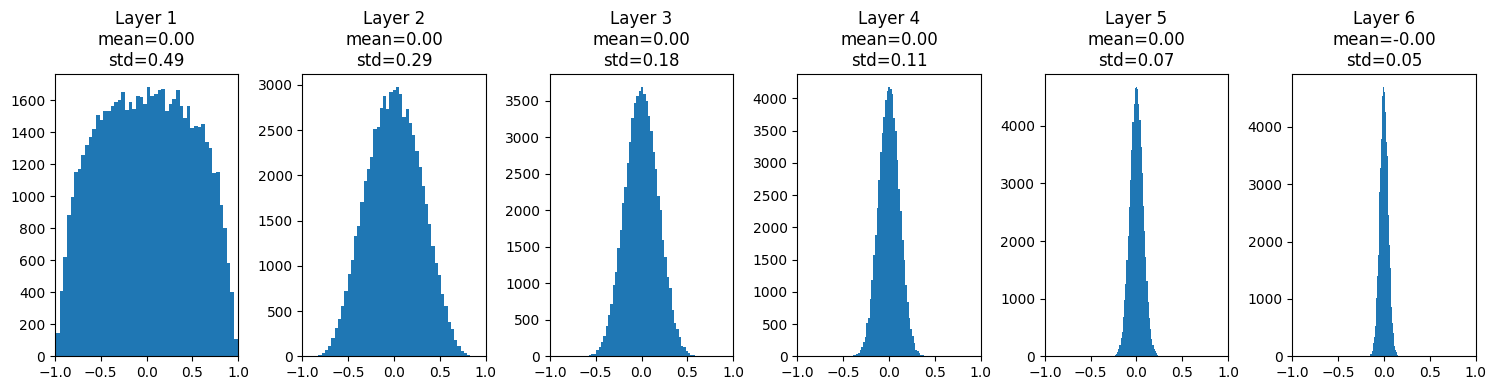

In [33]:
dims = [4096] * 7
hs = [] # store history
x = np.random.randn(16,dims[0])
for Din,Dout in zip(dims[:-1],dims[1:]):
    w = 0.01 * np.random.randn(Din,Dout)
    x = np.tanh(x@w.T)
    hs.append(x)
def simple_visualize(hs):
    fig, axs = plt.subplots(1, 6, figsize=(15, 4))
    
    for i in range(len(hs)):
        layer_data = hs[i].flatten()
        mean = np.mean(layer_data)
        std = np.std(layer_data)
        
        axs[i].hist(layer_data, bins=50, color='#1f77b4')
        axs[i].set_title(f"Layer {i+1}\nmean={mean:.2f}\nstd={std:.2f}")
        axs[i].set_xlim(-1, 1)
    
    plt.tight_layout()
    plt.show()

# 调用简化的可视化函数
simple_visualize(hs)

能够看到后续的activations会趋于0，模型无法学习

2. Xavier
之前造成activation趋于0的原因是因为方差的减小，使得后续的activation越来越集中
那就想一个办法，使得方差不再集中，让输入与输出的方差保持不变:
$W \sim \mathcal{N}(\mu, \sigma^2) \leftarrow Var(W) = \frac{1}{n_{in}}$



简单推导为什么这样就可以使得方差不再集中：
已知
$
W_{ji} \sim \mathcal{N}(0,\frac{1}{n_{in}}) \ \ x_i \sim \mathcal{N}(\mu, \sigma^2) \ \ 输入x_i和w_{ji}是iid.的\\
那么z_j = \sum_{i=1}^{n_{in}} W_{ji} \cdot x_i + b_j \ \ (b_j是bias，如果使用augmented notation可省略) \\ 
计算方差 Var(z_j) = Var(\sum_{i=1}^{n_{in}} W_{ji}\cdot x_i ) \overset{iid}{=} \sum_{i=1}^{n_{in}} Var(w_{ji} \cdot x_i) = \sum_{i=1}^{n_{in}} E[W_{ji}^2]E[x_i^2] - (E[W_{ji}]E[x_i])^2 \overset{E=0}{=} \sum_{i=1}^{n_{in}} E[W_{ji}^2]E[x_i^2] =  \sum_{i=1}^{n_{in}}Var(w_{ji}) Var(x_i) = n_{in} \cdot \frac{1}{n_{in}} \cdot \sigma^2  = \sigma^2  \\
对于tanh激活函数，在0附近有 tanh(z) \approx z\\
所以Var(tanh(z_j)) \approx Var(z_j) = \sigma_x^2\\
$
